In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('pix2pix-sketch-to-photo-2')
jovian.set_colab_id('13uAyGH2880UjpH43GeRg9icb-g926M_4')

# pix2pix-sketch-to-photo

out = ((input - kernel + 2*p)/stride ) + 1

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="pix2pix-sketch-to-photo-2")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/s-4-m-a-n/pix2pix-sketch-to-photo-2


'https://jovian.ai/s-4-m-a-n/pix2pix-sketch-to-photo-2'

# Reading dataset information

In [ ]:
import tarfile
import zipfile
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
with zipfile.ZipFile('gdrive/MyDrive/DataSets/complete dataset photo sketch.zip','r') as zip:
    zip.extractall('data/')

In [ ]:
DATA_DIR = "data/complete dataset photo sketch"
len(os.listdir(os.path.join(DATA_DIR,'train','photo'))) , len(os.listdir(os.path.join(DATA_DIR,'val','sketch')))

(246, 10)

In [ ]:
img_list = os.listdir(os.path.join(DATA_DIR,'train','photo'))

In [ ]:
test_list = os.listdir(os.path.join(DATA_DIR,'test','photo'))
len(test_list)

15

# Visualizing Data

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

(250, 200, 3)
(250, 200, 3)


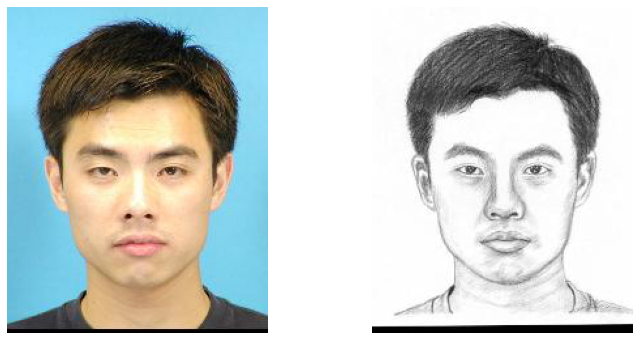

In [ ]:
img  = Image.open(os.path.join(DATA_DIR,'train/photo',img_list[0]))
sketch = Image.open(os.path.join(DATA_DIR,'train/sketch',img_list[0]))

print(np.array(img).shape)
print(np.array(sketch.convert('RGB')).shape)


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sketch , cmap='gray')
plt.axis('off')
plt.show()


# Discriminator Model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels,out_channels, 4,stride,padding=0,bias =False,padding_mode="reflect"),
                    nn.BatchNorm2d(out_channels),
                    nn.LeakyReLU(0.2)
        )

    def forward(self,x):
        return self.conv(x)

In [ ]:
((30-4)/1)+1

27.0

In [ ]:
((30-4+2)/1)+1

29.0

In [ ]:
# x,y ---> concatinate these along the channel
class Discriminator(nn.Module):
    def __init__(self,in_channels = 3 ,features=[64,128,256,512] ) :# 256*256 --> 30*30
        super().__init__()
        self.initial = nn.Sequential(
                nn.Conv2d(in_channels*2,features[0], kernel_size= 4, stride=2,padding=1,padding_mode='reflect'),
                nn.LeakyReLU(0.2)
        ) # inchannel --> 6  --> x and y is concatinated along channel wise
          # outchannel --> 64 --> 64 (4*4) kernel is used
          # [1x6x256x256] --> [1x64x128x128] [o = ((in - k + 2*p)/s )+1]

        layers = []
        in_channels = features[0]

        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels,feature, stride= 1 if feature == features[-1] else 2) 
            )
            # [1x64 x 128 x 128] --> [1x128 x 63 x 63 ]
            # [1x128 x 63 x 63] --> [1x256 x 30 x 30 ] 
            # [1 x 256 x 30 x 30 ]  --> [ 1 x 512 x 27 x 27 ]
            in_channels= feature

        # last layer

        layers.append(
            nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
        )
        #[1, 256 x 27 x 27] ---> [1 x 1 x 26 x 26]

        self.model = nn.Sequential(*layers)


    def forward(self,x,y):
        x = torch.cat([x,y],dim=1)
        x = self.initial(x)
        return self.model(x)



## checking model

In [ ]:
x = torch.randn((2,3,256,256))
y = torch.randn((2,3,256,256))
x.shape,y.shape

(torch.Size([2, 3, 256, 256]), torch.Size([2, 3, 256, 256]))

In [ ]:
model = Discriminator()
pred = model(x,y)
print(pred.shape)

torch.Size([2, 1, 26, 26])


# Building Generator

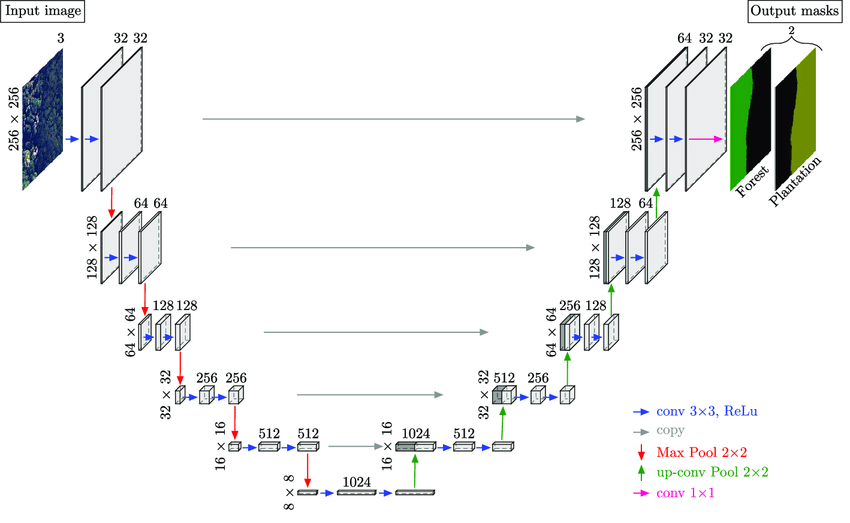

In [ ]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True , act = 'relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False,padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,stride=2,padding=1,bias=False),

            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self,x):
      x = self.conv(x)
      return self.dropout(x) if self.use_dropout else x



In [ ]:
128*2

256

In [ ]:
class Generator(nn.Module):
    def __init__(self,in_channels=3,features=64):
      super().__init__()
      #Down sampling
      self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels,features,kernel_size = 4 , stride = 2 , padding= 1 , bias=False,padding_mode='reflect'),
            nn.LeakyReLU(0.2)   
      ) # [1 ,3, 256 , 256]  -> [1, 64 , 128, 128]
      
      self.down1 = Block(features,features*2,down=True,act='leaky',use_dropout=False) #[1,64,128,128] -> [1,128,64,64]
      self.down2 = Block(features*2,features*4,down=True,act='leaky',use_dropout=False) #[1,128,64,64] ->[1,256,32,32]
      self.down3 = Block(features*4,features*8,down=True,act='leaky',use_dropout=False) # [1,256,32,32] ->[1,512,16,16]
      self.down4 = Block(features*8,features*8,down=True,act='leaky',use_dropout=False) # [1,512,16,16] --> [1,512,8,8] 
      self.down5 = Block(features*8,features*8,down=True,act='leaky',use_dropout=False) # [1,512,8,8] --> [1,512,4,4]
      self.down6 = Block(features*8,features*8,down=True,act='leaky',use_dropout=False) # [1,512,4,4] --> [1,512,2,2]

      self.bottleneck  = nn.Sequential(
          nn.Conv2d(features*8,features*8,4,2,1,padding_mode = 'reflect'),
          nn.ReLU()
      ) #[1, 512, 2 , 2] --> [1, 512, 1, 1]

      #upSampling 
      # here were are doubling the input features because apply skip+concatination
      self.up1 = Block(features*8,features*8,down=False,act='relu', use_dropout=True) #[1, 512,1,1] --> [1, 512 , 2 ,2]
      self.up2 = Block(features*8*2,features*8,down=False,act='relu', use_dropout=True) #[1,512*2 , 2 ,2] --> [1 , 512 , 4, 4]
      self.up3 = Block(features*8*2,features*8,down=False,act='relu', use_dropout=True) # [1 , 512*2, 4,4] --> [1, 512, 8, 8] 
      self.up4 = Block(features*8*2,features*8,down=False,act='relu', use_dropout=True) # [1, 512*2, 8, 8] --> [1, 512, 16, 16]
      self.up5 = Block(features*8*2,features*4,down=False,act='relu', use_dropout=True) # [1, 512*2, 16, 16] --> [1, 256, 32 ,32]
      self.up6 = Block(features*4*2,features*2,down=False,act='relu', use_dropout=True) # [1, 256 *2 , 32, 32 ]  --> [1 ,128 , 64,64]
      self.up7 = Block(features*2*2,features,down=False,act='relu', use_dropout=True)   # [1,128*2 , 64, 64] --> [1,64, 128, 128]

      self.final_up  = nn.Sequential(
          
                  nn.ConvTranspose2d(features*2,in_channels,kernel_size=4,stride=2,padding=1),
                  nn.Tanh(), # this ensure that our pix value ranges from -1 to 1
      ) #[1,64*64, 128 , 128]  --> [1, 3, 256 , 256] 

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1,d7],1))
        up3 = self.up3(torch.cat([up2,d6],1))
        up4 = self.up4(torch.cat([up3,d5],1))
        up5 = self.up5(torch.cat([up4,d4],1))
        up6 = self.up6(torch.cat([up5,d3],1))
        up7 = self.up7(torch.cat([up6,d2],1))
        return self.final_up(torch.cat([up7,d1],1))




In [ ]:
x = torch.randn((4,3,256,256))
model = Generator()
pred = model(x)
x.shape

torch.Size([4, 3, 256, 256])

In [ ]:
pred.shape

torch.Size([4, 3, 256, 256])

In [ ]:
pred[0,0,:5,:5]

tensor([[-0.5101,  0.8549,  0.0464,  0.1958,  0.8734],
        [-0.0736,  0.6145,  0.5454, -0.7522, -0.2121],
        [ 0.3733,  0.3652,  0.8037, -0.0920,  0.5610],
        [-0.2148, -0.7766,  0.5599, -0.9929, -0.1915],
        [ 0.0338, -0.6821, -0.9692, -0.5331,  0.6593]],
       grad_fn=<SliceBackward>)

# Custom Dataset Loading

In [ ]:
!pip install albumentations==0.4.6 -q

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from tqdm.notebook  import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor 
import torchvision.transforms as T
import os
from PIL import Image

In [ ]:
A.__version__

'0.4.6'

In [ ]:
resize_image = T.Resize((256,256))

both_transform = A.Compose([ 
     A.HorizontalFlip(0.5),
     ], additional_targets={'image':'image0'})

In [ ]:
transform_only_input= A.Compose(
    [#T.ColorJitter(),
     A.Normalize(mean=[0.5,0.5,0.5] , std =[0.5,0.5,0.5], max_pixel_value=255.),
     ToTensorV2() #[height, width , numChannel]  --> [numChannel,width, height]
    ]
)

In [ ]:
transform_only_target= A.Compose(
    [ 
     A.Normalize(mean=[0.5,0.5,0.5] , std =[0.5,0.5,0.5], max_pixel_value=255.),
     ToTensorV2()
    ]
)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
class MapDataset(Dataset):
    def __init__(self,root_dir,file_dir='photo'):
       super().__init__()
       self.root_dir = root_dir
       self.list_files = os.listdir(os.path.join(self.root_dir,file_dir))

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self,index):
          image_file_name = self.list_files[index]
          photo_path = os.path.join(self.root_dir,'photo',image_file_name)
          sketch_path = os.path.join(self.root_dir,'sketch',image_file_name)

          target_img = np.array(Image.open(photo_path).convert('LA').convert('RGB')) # [height, width, numChannel]
          input_img = np.array(Image.open(sketch_path).convert('RGB')) #converting grayscale image into RGB and then transfering into numpy array
          
          
          

          #applying composite transformation
          transform = both_transform(image=input_img, image0=target_img )
          input_img , target_img = transform['image'] , transform['image0']


          input_img = transform_only_input(image=input_img)["image"]
          target_img = transform_only_target(image=target_img)["image"]

                #resizing
          input_img = resize_image(input_img)
          target_img= resize_image(target_img)

          return input_img, target_img



# Utils

In [ ]:
def save_some_examples(gen,val_loader,epoch,folder):
    x , y = next(iter(val_loader))
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x.to(DEVICE))
        y_fake = y_fake *0.5 + 0.5 #denormalize
        save_image(y_fake,folder+f"y_gen{epoch}.png")

        if epoch == 5:
            save_image(x,f"input_{epoch}.png")
            save_image(y.to(DEVICE)*0.5+0.5,f"label_{epoch}.png")
    gen.train()



In [ ]:
def save_checkpoints(model,optimizer,file_name='By_checkpoints.pth.tar'):
    print("!!!!!!saving checkpoints!!!!!!")
    checkpoint = {
        'state_dict' : model.state_dict(),
        'optimizer':optimizer.state_dict()
    }

    torch.save(checkpoint,file_name)

In [ ]:
def load_checkpoints(checkpoint_file,model,optimizer,lr):
    print("loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    for param_group in optimizer.param_groups:
        param_group['lr']=lr 

# Training 

In [ ]:
SAVE_CHECKPOINT =True
LOAD_CHECKPOINT = False
CHECKPOINT_DISC = 'disc.pth.tar'
CHECKPOINT_GEN = 'gen.pth.tar'
L1_LAMBDA = 100 #100
NUM_EPOCH = 350
LR = 2e-4 # 2e-4
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
BATCH_SIZE = 4 #4
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
DRIVE_DIR = "gdrive/MyDrive/DataSets/pix2pix sketch to photo/"




In [ ]:
def train_func(disc_model,gen_model,train_dl, opt_disc, opt_gen, L1_loss, BCE,g_scaler, d_scaler):
  # loop = tqdm(train_dl, leave=True)
   for (x , y) in tqdm(train_dl):
       
        x , y = x.to(DEVICE) , y.to(DEVICE)
        # train discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen_model(x)
            D_real = disc_model(x,y)
            D_fake = disc_model(x,y_fake.detach())

            D_real_loss = BCE(D_real,torch.ones_like(D_real))
            D_fake_loss = BCE(D_fake,torch.zeros_like(D_fake))

            D_loss = (D_real_loss + D_fake_loss) / 2

        disc_model.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # train generator

        with torch.cuda.amp.autocast():
            D_fake = disc_model(x,y_fake)
            G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))
            L1 = L1_loss(y_fake,y) * L1_LAMBDA
            G_loss = G_fake_loss + L1


        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()



                                    

In [ ]:
torch.cuda.is_available()

True

In [ ]:
disc_model = Discriminator().to(DEVICE)
gen_model = Generator().to(DEVICE)

In [ ]:
def fit():
    
    opt_disc = torch.optim.Adam(disc_model.parameters(),lr=LR,betas=(0.5,0.999))
    opt_gen = torch.optim.Adam(gen_model.parameters(),lr=LR,betas=(0.5,0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_loss = nn.L1Loss()

    if LOAD_CHECKPOINT : 
        load_checkpoints(DRIVE_DIR +CHECKPOINT_GEN,gen_model,opt_gen,LR)
        load_checkpoints(DRIVE_DIR +CHECKPOINT_DISC, disc_model,opt_disc,LR)


    train_ds = MapDataset(root_dir='data/complete dataset photo sketch/train')
    val_ds = MapDataset(root_dir='data/complete dataset photo sketch/val')

    train_dl = DataLoader(train_ds,batch_size = BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
    val_dl = DataLoader(val_ds,batch_size=BATCH_SIZE,num_workers=2,pin_memory=True)

  
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCH):
        train_func(disc_model,gen_model,train_dl, opt_disc, opt_gen, L1_loss, BCE,g_scaler,d_scaler)

        if SAVE_CHECKPOINT and epoch % 5 == 0 :
            save_checkpoints(gen_model,opt_gen,file_name=DRIVE_DIR +CHECKPOINT_GEN)
            save_checkpoints(disc_model, opt_disc,file_name=DRIVE_DIR +CHECKPOINT_DISC)
            save_some_examples(gen_model,val_dl,epoch,folder="evaluation/")

In [ ]:
fit()


!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!



!!!!!!saving checkpoints!!!!!!
!!!!!!saving checkpoints!!!!!!


In [ ]:
# train_ds = MapDataset(root_dir='data/complete dataset photo sketch/train')
# val_ds = MapDataset(root_dir='data/complete dataset photo sketch/val')

# len(train_ds)
# x , y = train_ds[0]
# x.shape
# t = T.Resize((256,256))
# t(x).shape

# train_dl = DataLoader(train_ds,batch_size = BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
# val_dl = DataLoader(val_ds,batch_size=BATCH_SIZE,num_workers=2,pin_memory=True)
# for batch in train_dl:
#     print(batch[0].shape)
#     break;


In [ ]:
np.array(Image.open("00.png").convert('LA').convert('RGB')).shape

# Dumping Model

In [ ]:
import pickle

In [ ]:
gen_model_file = 'generator.pkl'
disc_model_file = 'dis.pkl'

root_dir = 'gdrive/MyDrive/DataSets/complete dataset photo sketch'



In [ ]:
pickle.dump(gen_model,open(os.path.join(root_dir,gen_model_file),'wb'))
pickle.dump(disc_model,open(os.path.join(root_dir,disc_model_file),'wb'))

# Loading model

In [ ]:
generator_model = pickle.load(open(os.path.join(root_dir,gen_model_file),'rb'))

# Test Model

In [ ]:
def Image_as_dl(file_path):
    input_img = np.array(Image.open(file_path))

    input_img = transform_only_input(image=input_img)["image"]


          #resizing
    input_img = resize_image(input_img)
    
    return (input_img).unsqueeze(0)


In [ ]:
img = Image_as_dl("sketch1.jpg")
img.shape

In [ ]:
def show_image(image):
  plt.imshow(image.squeeze(0).permute(1,2,0)*0.5+0.5)
  plt.axis('off')

In [ ]:
show_image(img)

In [ ]:
sketch_gen = generator_model(img.to(DEVICE))

In [ ]:
show_image(sketch_gen.to('cpu').detach())

In [ ]:
jovian.commit()